In [21]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [22]:
file_paths = glob.glob('./data/*.csv')

#creates a merged df though not sure if this is useful
dataframes = []

for file in file_paths:
    df = pd.read_csv(file, sep=';')
    dataframes.append(df)

merged_df = pd.concat(dataframes)
#merged_df.to_csv('./data/', index=False)



In [23]:
monday = pd.read_csv('./data/monday.csv', sep=';')
tuesday = pd.read_csv('./data/tuesday.csv', sep=';')
wednesday = pd.read_csv('./data/wednesday.csv', sep=';')
thursday = pd.read_csv('./data/thursday.csv', sep=';')
friday = pd.read_csv('./data/friday.csv', sep=';')

days_data = [monday, tuesday, wednesday, thursday, friday]

In [24]:
#add day column to each in preparation for merging
monday['day'] = 'monday'
tuesday['day'] = 'tuesday'
wednesday['day'] = 'wednesday'
thursday['day'] = 'thursday'
friday['day'] = 'friday'

In [25]:
for day in days_data:
    day.timestamp = pd.to_datetime(day.timestamp)
    day.set_index('timestamp', inplace=True)

In [26]:
#this will deal with the customers who didn't check out
def get_non_checkout(df):
    non_checkout_customers = df['customer_no'].max()
    checkout_customers = []
    for c_id in range(non_checkout_customers):
        if not 'checkout' in df[df['customer_no'] == c_id+1]['location'].values:
            checkout_customers.append(c_id+1)
    return checkout_customers

In [27]:
#this should now make it 
customers_to_checkout = []
for day in days_data:
    customers_to_checkout.append(get_non_checkout(day))
    

In [28]:
def add_checkout(df, customer_nos, date, day):
    df_fill = pd.DataFrame()
    for p_id in customer_nos:
        df_tmp = pd.DataFrame(data=[[p_id, 'checkout', day]], index=[pd.to_datetime(f'2019-09-{date} 21:59:00')], columns=['customer_no', 'location', 'day'])
        df = pd.concat([df, df_tmp])
    return df

In [29]:
filled_data = []
weekdays = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday']
date = ['02', '03', '04', '05', '06']
for i, day in enumerate(days_data):
    filled_data.append(add_checkout(day, customers_to_checkout[i], date[i], weekdays[i]))

In [30]:
total = pd.concat(filled_data)

In [31]:
total

,customer_no,location,day
2019-09-02 07:03:00,1,dairy,monday
2019-09-02 07:03:00,2,dairy,monday
2019-09-02 07:04:00,3,dairy,monday
2019-09-02 07:04:00,4,dairy,monday
2019-09-02 07:04:00,5,spices,monday
...,...,...,...
2019-09-06 21:59:00,1503,checkout,friday
2019-09-06 21:59:00,1505,checkout,friday
2019-09-06 21:59:00,1506,checkout,friday
2019-09-06 21:59:00,1509,checkout,friday


In [32]:
monday.describe()

,customer_no
count,4884.000000
mean,718.274365
std,411.839636
min,1.000000
25%,366.000000
50%,720.000000
75%,1070.000000
max,1447.000000


In [33]:
#no missing data
monday

,customer_no,location,day
timestamp,,,
2019-09-02 07:03:00,1,dairy,monday
2019-09-02 07:03:00,2,dairy,monday
2019-09-02 07:04:00,3,dairy,monday
2019-09-02 07:04:00,4,dairy,monday
2019-09-02 07:04:00,5,spices,monday
...,...,...,...
2019-09-02 21:49:00,1442,checkout,monday
2019-09-02 21:49:00,1444,checkout,monday
2019-09-02 21:49:00,1445,dairy,monday


#this is a datetime index
datetime = pd.to_datetime(monday['timestamp'])
monday.index = pd.DatetimeIndex(datetime)
monday = monday.drop(['timestamp'], axis=1)

In [34]:
thursday.groupby(['customer_no']).size().mean()


3.3250814332247556

<Axes: ylabel='Count'>

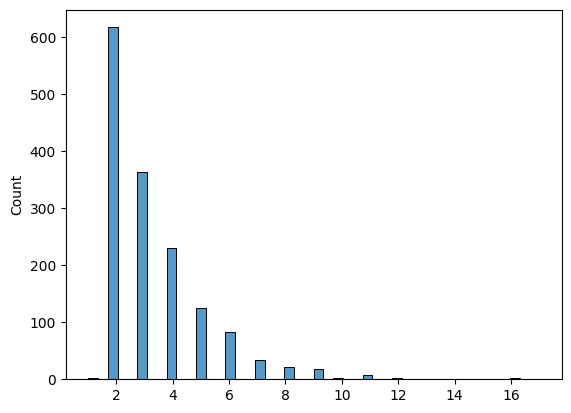

In [35]:
sns.histplot(friday.groupby(['customer_no']).size())

In [36]:
#this should show the average size of the trips by customer no, they all hover around 3.3 as an average, its a right skewed tail on all of them

monday.groupby(['customer_no']).size().mean()



3.3752591568762957

<Axes: ylabel='Count'>

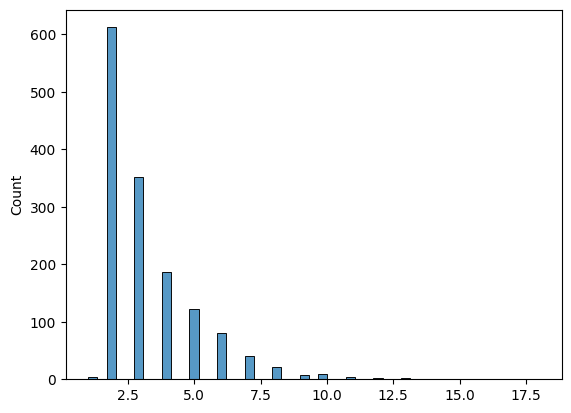

In [37]:
#this confirms the right skew of the tail
sns.histplot(monday.groupby(['customer_no']).size())

In [38]:
# Showing how many customers are present on how many locations over time

monday.groupby(by=['timestamp']).nunique()

,customer_no,location,day
timestamp,,,
2019-09-02 07:03:00,2,1,1
2019-09-02 07:04:00,6,3,1
2019-09-02 07:05:00,4,3,1
2019-09-02 07:06:00,8,5,1
2019-09-02 07:07:00,4,4,1
...,...,...,...
2019-09-02 21:46:00,6,4,1
2019-09-02 21:47:00,6,3,1
2019-09-02 21:48:00,7,4,1


In [39]:
#unstack is super useful in context, need to figure that one out a bit
monday.groupby(['timestamp', 'location']).count().unstack(level=1).fillna(0)

customer_no                                day         
location               checkout dairy drinks fruit spices checkout dairy   
timestamp                                                                  
2019-09-02 07:03:00         0.0   2.0    0.0   0.0    0.0      0.0   2.0  \
2019-09-02 07:04:00         0.0   2.0    0.0   1.0    3.0      0.0   2.0   
2019-09-02 07:05:00         2.0   1.0    1.0   0.0    0.0      2.0   1.0   
2019-09-02 07:06:00         2.0   2.0    1.0   2.0    1.0      2.0   2.0   
2019-09-02 07:07:00         1.0   1.0    1.0   0.0    1.0      1.0   1.0   
...                         ...   ...    ...   ...    ...      ...   ...   
2019-09-02 21:46:00         1.0   0.0    2.0   1.0    2.0      1.0   0.0   
2019-09-02 21:47:00         2.0   2.0    0.0   2.0    0.0      2.0   2.0   
2019-09-02 21:48:00         2.0   2.0    2.0   0.0    1.0      2.0   2.0   
2019-09-02 21:49:00         2.0   1.0    0.0   2.0    2.0      2.0   1.0   
2019-09-02 21:50:00         0.0   1.0    0.0   1.0    0.0      0.0   1.0   

                                         
location            drinks fruit spices  
timestamp                                
2019-09-02 07:03:00    0.0   0.0    0.0  
2019-09-02 07:04:00    0.0   1.0    3.0  
2019-09-02 07:05:00    1.0   0.0    0.0  
2019-09-02 07:06:00    1.0   2.0    1.0  
2019-09-02 07:07:00    1.0   0.0    1.0  
...                    ...   ...    ...  
2019-09-02 21:46:00    2.0   1.0    2.0  
2019-09-02 21:47:00    0.0   2.0    0.0  
2019-09-02 21:48:00    2.0   0.0    1.0  
2019-09-02 21:49:00    0.0   2.0    2.0  
2019-09-02 21:50:00    0.0   1.0    0.0  

[874 rows x 10 columns]

In [40]:
#there are dupes, add a row to confirm that
monday['duplicate'] = monday.duplicated(['customer_no', 'location'])
monday['duplicate'].value_counts()


duplicate
False    4229
True      655
Name: count, dtype: int64

In [41]:
#there are dupes, add a row to confirm that
tuesday['duplicate'] = tuesday.duplicated(['customer_no', 'location'])
tuesday['duplicate'].value_counts()

duplicate
False    4122
True      592
Name: count, dtype: int64

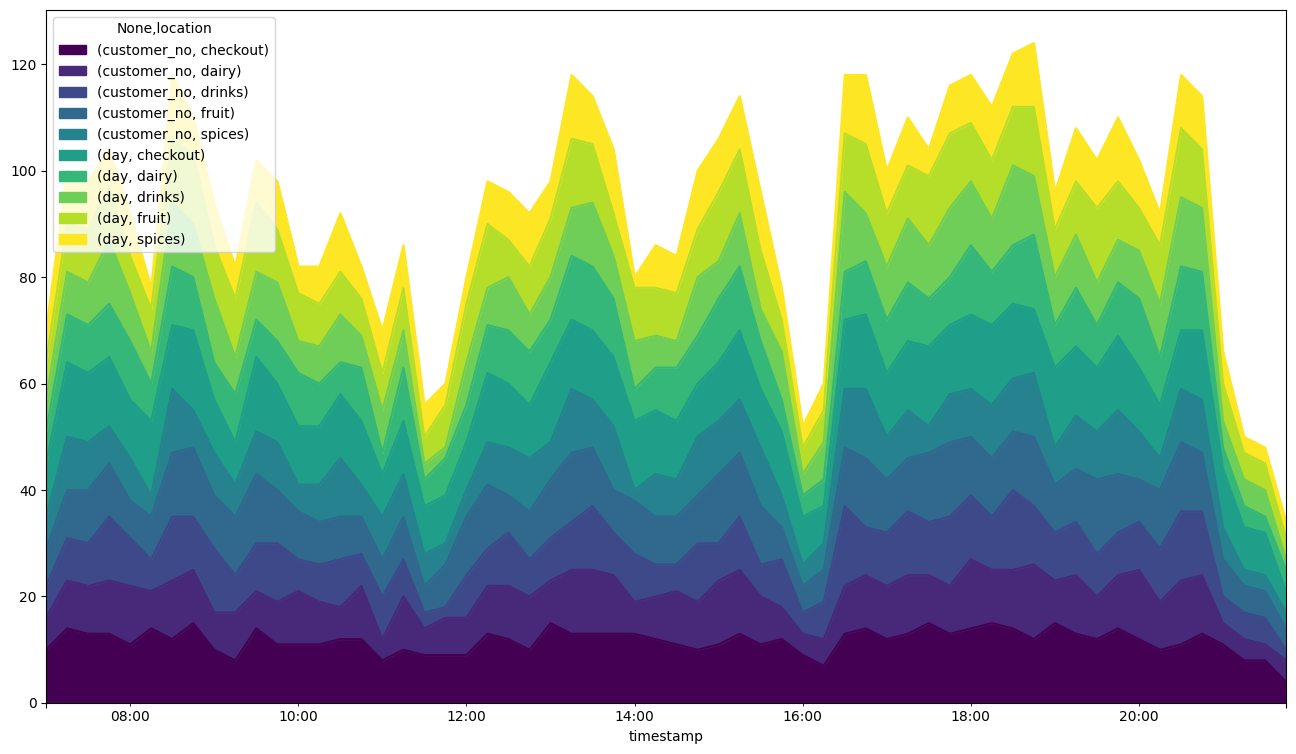

In [42]:
monday.drop('duplicate', axis=1).groupby(['timestamp', 'location']).count().unstack(level=1).resample('15T').count().plot.area(cmap='viridis')
plt.gcf().set_size_inches(16, 9)

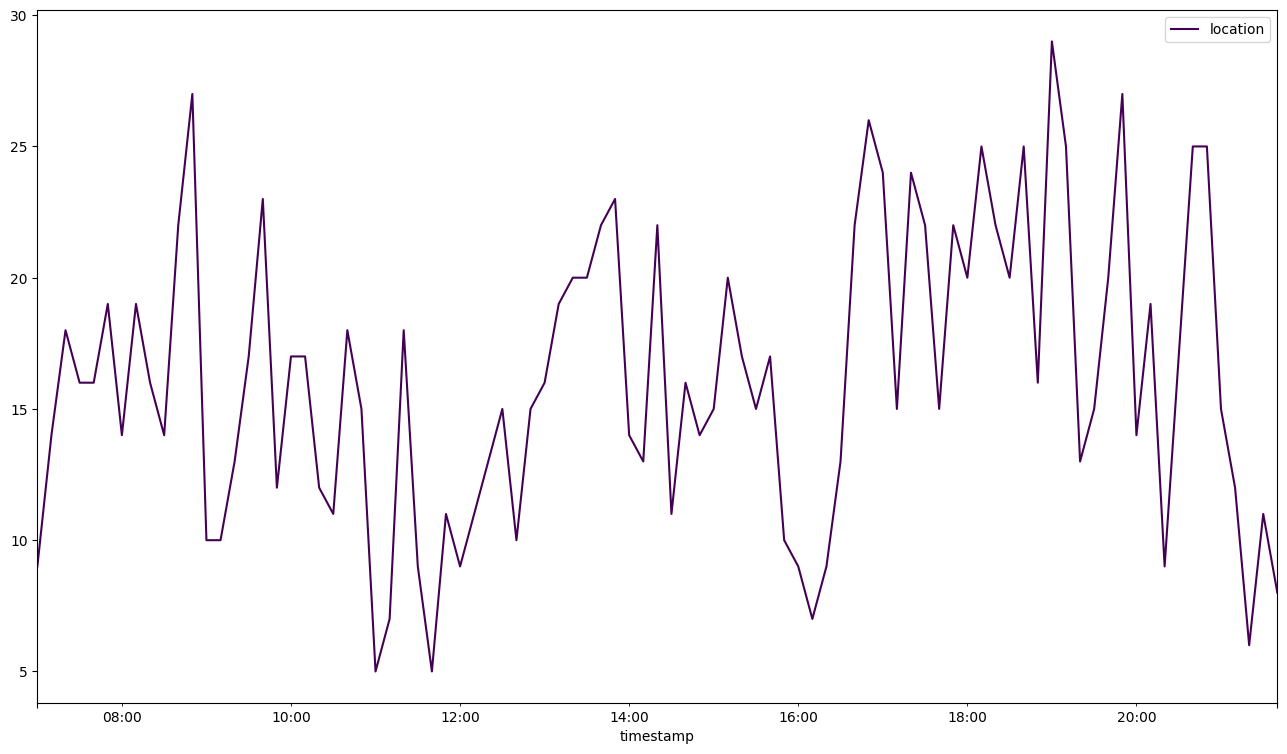

In [43]:
#shows the checkouts over time
monday[monday['location'] == 'checkout'].resample('10T').count().plot(y='location', cmap='viridis')
plt.gcf().set_size_inches(16, 9)